In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

dates = pd.date_range(start="2022-01-01", end="2024-12-31", freq="M")

records = []

for month in dates:
    n_events = np.random.poisson(lam=3)  # average ~3 payments/month
    
    for _ in range(n_events):
        record = {
            "date": month - pd.to_timedelta(np.random.randint(0, 27), unit="D"),
            "amount_eur": round(np.random.lognormal(mean=7.5, sigma=0.6), 2),
            "source": np.random.choice(
                ["Theater A", "Theater B", "Festival", "Teaching", "Other"]
            ),
            "category": np.random.choice(
                ["performance", "rehearsal", "teaching", "other"]
            ),
        }
        records.append(record)

income_events = pd.DataFrame(records)

/var/folders/km/_6m5pc752fd1k90_0hgwkkv00000gn/T/ipykernel_6752/1431764259.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2022-01-01", end="2024-12-31", freq="M")


In [2]:
income_events

,date,amount_eur,source,category
0,2022-01-13,1708.25,Other,other
1,2022-01-24,1035.57,Festival,rehearsal
2,2022-01-11,1275.98,Other,performance
3,2022-01-20,1319.35,Theater B,rehearsal
4,2022-04-15,1555.22,Festival,other
...,...,...,...,...
86,2024-10-23,1412.65,Teaching,rehearsal
87,2024-11-26,3263.04,Festival,other
88,2024-11-06,761.74,Other,teaching
89,2024-11-15,2125.13,Theater A,teaching


In [3]:
monthly = (
    income_events
    .assign(year_month=income_events['date'].dt.to_period('M'))  # truncate to month
    .groupby('year_month', as_index=False)['amount_eur']
    .sum()
    .rename(columns={'amount_eur': 'monthly_income'})
)

In [4]:
monthly

,year_month,monthly_income
0,2022-01,5339.15
1,2022-04,3193.95
2,2022-05,5893.42
3,2022-06,8006.53
4,2022-07,3873.00
5,2022-08,3811.40
6,2022-09,10147.13
7,2022-10,5416.78
8,2022-11,2535.86
9,2022-12,4262.55


In [5]:
monthly['rolling_3m'] = monthly['monthly_income'].rolling(window=3).mean()

In [17]:
monthly['rolling_3m']

0              NaN
1              NaN
2      4808.840000
3      5697.966667
4      5924.316667
5      5230.310000
6      5943.843333
7      6458.436667
8      6033.256667
9      4071.730000
10     2608.390000
11     4483.543333
12     5911.066667
13     6345.723333
14     4122.066667
15     3032.566667
16    10751.840000
17    10930.756667
18    10839.486667
19     5243.100000
20     6600.403333
21     6465.326667
22     4961.610000
23     3309.333333
24     4565.566667
25     7335.913333
26    11550.850000
27    10808.440000
28     9881.210000
29     7335.516667
30     6021.400000
Name: rolling_3m, dtype: float64

In [6]:
threshold = 2000
monthly['low_income'] = monthly['monthly_income'] < threshold

In [18]:
coverage = 0.9

buffer = monthly['monthly_income'].quantile(1 - coverage)

print(f"Recommended cash buffer: €{buffer:.2f}")

Recommended cash buffer: €2027.10


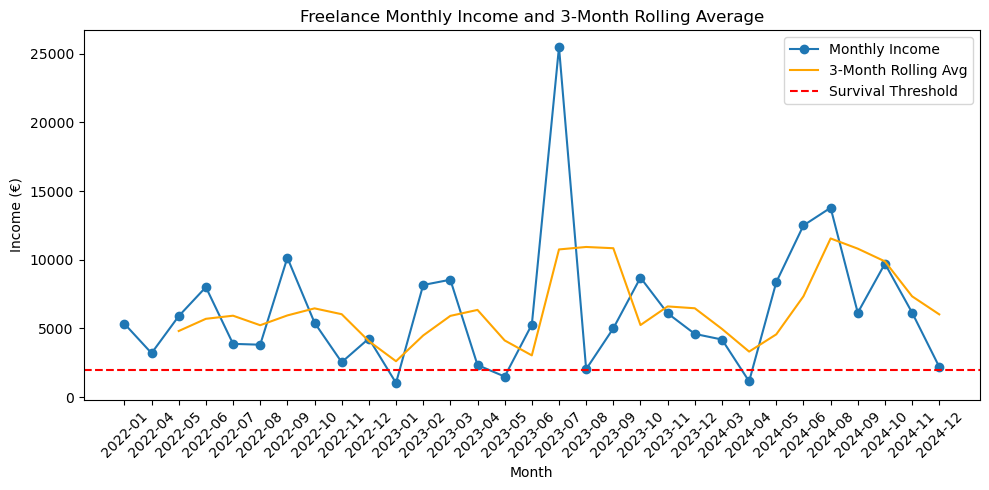

In [9]:
import matplotlib.pyplot as plt

# Compute rolling 3-month average
monthly['rolling_3m'] = monthly['monthly_income'].rolling(window=3).mean()

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly['year_month'].astype(str), monthly['monthly_income'], label='Monthly Income', marker='o')
plt.plot(monthly['year_month'].astype(str), monthly['rolling_3m'], label='3-Month Rolling Avg', color='orange')
plt.axhline(y=threshold, color='red', linestyle='--', label='Survival Threshold')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Income (€)')
plt.title('Freelance Monthly Income and 3-Month Rolling Average')
plt.legend()
plt.tight_layout()
plt.show()

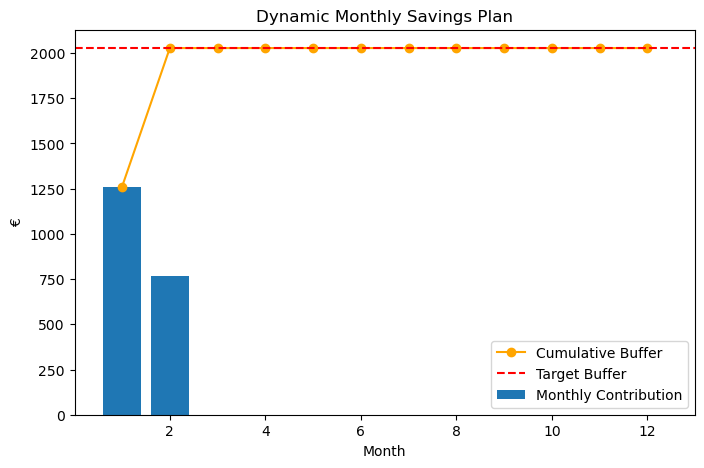

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Settings
buffer_target = buffer       # from previous step
months = 12                  # months to reach buffer
max_fraction = 0.2           # max % of average income to save
avg_income = monthly['monthly_income'].mean()

# Initialize
current_buffer = 0
monthly_savings = []

for month_idx in range(1, months + 1):
    remaining_buffer = buffer_target - current_buffer
    contribution = min(remaining_buffer, avg_income * max_fraction)
    current_buffer += contribution
    monthly_savings.append(contribution)

# Create DataFrame for plotting
savings_plan = pd.DataFrame({
    'Month': range(1, months + 1),
    'Monthly_Contribution': monthly_savings,
    'Cumulative_Buffer': np.cumsum(monthly_savings)
})

# Plot
plt.figure(figsize=(8,5))
plt.bar(savings_plan['Month'], savings_plan['Monthly_Contribution'], label='Monthly Contribution')
plt.plot(savings_plan['Month'], savings_plan['Cumulative_Buffer'], color='orange', marker='o', label='Cumulative Buffer')
plt.axhline(y=buffer_target, color='red', linestyle='--', label='Target Buffer')
plt.xlabel('Month')
plt.ylabel('€')
plt.title('Dynamic Monthly Savings Plan')
plt.legend()
plt.show()

In [13]:
print(monthly['monthly_income'].avg)

AttributeError: 'Series' object has no attribute 'avg'

monthly['monthly_income'].mean()

In [15]:
print(monthly['monthly_income'].mean())

6303.591290322579


In [16]:
low_months_count = monthly['low_income'].sum()
print(f"Number of low-income months: {low_months_count}")

Number of low-income months: 3
